In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SSLimPy.interface.sslimpy as sslimpy

import astropy.units as u

In [2]:
cosmodict={"h":0.67,"Omegam":0.32,"Omegab":0.04,"As":2.1e-9, "mnu":0.06}
settings = {"code":"class"}

Asslimpy = sslimpy.sslimpy(settings_dict=settings,
                           cosmopars=cosmodict)

#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#
/home/sefa/Schreibtisch/LIM-code/SSLimPy/SFR_tables/


In [3]:
Asslimpy.fiducialcosmo.sigma8_of_z(0)

array(0.85972152)

In [4]:
Asslimpy.fiducialcosmo.sigmaR_of_z(0,(8/0.67)*u.Mpc)

<Quantity 0.85974762>

In [5]:
k= np.geomspace(1e-3,1,200)
z= np.array(range(4))
M = np.geomspace(1e7*u.Msun,1e11*u.Msun)
sigma_m_z = Asslimpy.fiducialastro.sigmaM_of_z(M,z)


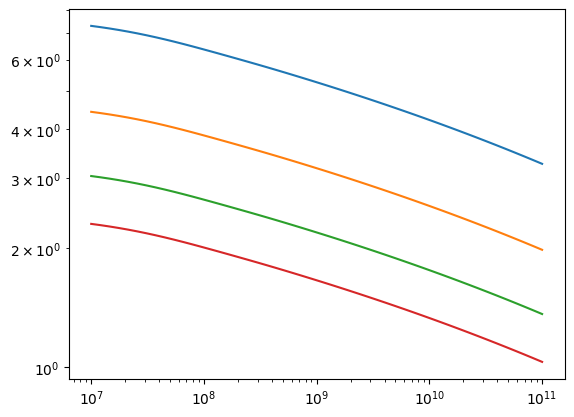

In [6]:
plt.loglog(M,sigma_m_z)

In [14]:
import os
from scipy.interpolate import interp2d, RectBivariateSpline
import numpy as np

In [9]:
SFR_file = "/home/sefa/Schreibtisch/LIM-code/SSLimPy/SFR_tables/sfr_release.dat"


In [10]:

x = np.loadtxt(SFR_file)
zb = np.unique(x[:,0])-1.
logMb = np.unique(x[:,1])
logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')

logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)

/tmp/ipykernel_77607/511984872.py:6: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)


In [11]:
zb.shape

(137,)

In [12]:
logMb.shape

(122,)

In [13]:
logSFRb.shape

(137, 122)

In [18]:
logSFR_interp = RectBivariateSpline(logMb,zb,logSFRb.T)